In [1]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
from sklearn.externals import joblib

from gensim.models.keyedvectors import KeyedVectors as wk


%matplotlib inline

2018-11-08 23:09:46,229 : INFO : 'pattern' package not found; tag filters are not available for English


In [2]:
df=pd.read_csv("shuffled_movie_data.csv")
df=df.dropna()
df.tail()
df['review'].apply(lambda x: len(x.split(' '))).sum()

11557297

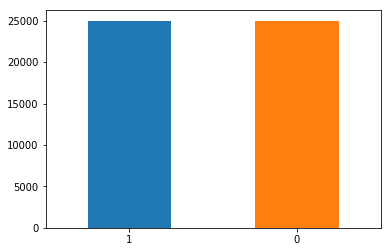

In [3]:
my_tags=['negative','positive']
df.sentiment.value_counts().plot(kind="bar", rot=0)

In [4]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


In [5]:
len(train_data)
len(test_data)

10000

In [6]:
words=np.load("words.npy").item()
tmp=words["absolve"]
print(tmp.max())
print(tmp.min())
print(tmp.mean())

0.6796875
-0.5078125
0.011801173


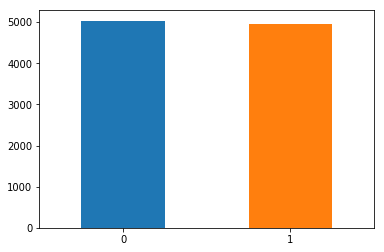

In [7]:
test_data.sentiment.value_counts().plot(kind="bar",rot=0)

In [8]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [10]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['review'])
    predictions = classifier.predict(data_features)
    target = data['sentiment']
    evaluate_prediction(predictions, target)

# Baseline: bag of words, n-grams, tf-idf

#### Bag of words

In [11]:
%%time
# training
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000) 
train_data_features = count_vectorizer.fit_transform(train_data['review'])

CPU times: user 56.9 s, sys: 87.4 ms, total: 57 s
Wall time: 57 s


In [12]:
train_data_features[:3]

<3x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 156 stored elements in Compressed Sparse Row format>

In [13]:
%%time
logreg=linear_model.LogisticRegression(n_jobs=1,C=1e5)
logrog=logreg.fit(train_data_features,train_data['sentiment'])

/home/richard/home/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 12.1 s, sys: 55.9 ms, total: 12.2 s
Wall time: 11.6 s


In [14]:
count_vectorizer.get_feature_names()[:20]

['!',
 '#',
 '$',
 '%',
 '&',
 "'",
 "''",
 "'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'the",
 "'ve",
 '(',
 ')',
 '*',
 '***',
 '****',
 ',']

accuracy 0.8699
confusion matrix
 [[4333  701]
 [ 600 4366]]
(row=expected, col=predicted)
CPU times: user 14.9 s, sys: 0 ns, total: 14.9 s
Wall time: 14.9 s


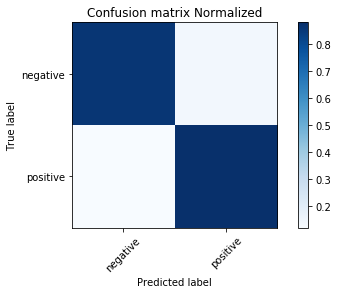

In [15]:
%%time
predict(count_vectorizer,logreg,test_data)

### Character N-grams

In [ ]:
%%time
n_gram_vectorizer=CountVectorizer(
    analyzer="char",
    ngram_range=([2,5]),
    tokenizer=None,preprocessor=None,
    max_features=3000)

logreg=linear_model.LogisticRegression(n_jobs=1,C=1e5)
train_data_features=n_gram_vectorizer.fit_transform(train_data['review'])
logreg=logreg.fit(train_data_features,train_data['sentiment'])

In [ ]:
n_gram_vectorizer.get_feature_names()[3050:3060]

In [ ]:
%%time
predict(n_gram_vectorizer, logreg, test_data)


# WORDTOVEC

In [15]:
%%time

wv = wk.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)


2018-11-08 23:11:49,842 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2018-11-08 23:13:23,296 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin.gz
2018-11-08 23:13:23,297 : INFO : precomputing L2-norms of word weight vectors


CPU times: user 1min 50s, sys: 2.33 s, total: 1min 52s
Wall time: 1min 55s


In [16]:
from itertools import islice
list(islice(wv.vocab, 13000, 13020))

['indoors',
 'commercially',
 'scouts',
 'State_Condoleezza_Rice',
 'Election_Day',
 'satellites',
 'Dalton',
 'Pack',
 'Marina',
 'Cherry',
 'selective',
 'dear',
 'scout',
 'blogger',
 'Tony_Blair',
 'Nairobi',
 'Zurich',
 'Milford',
 'Notes_@',
 'motel']

In [17]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.layer1_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv,review) for review in text_list])

In [18]:
'''
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
'''
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            if word in stopwords.words('english'):
                continue
            tokens.append(word)
    return tokens

In [ ]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['review']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['review']), axis=1).values

In [25]:
%%time
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

NameError: name 'train_tokenized' is not defined

In [21]:
%%time
knn_naive_dv = KNeighborsClassifier(n_neighbors=3, n_jobs=1, algorithm='brute', metric='cosine' )
knn_naive_dv.fit(X_train_word_average, train_data.sentiment)

CPU times: user 15.1 ms, sys: 0 ns, total: 15.1 ms
Wall time: 122 ms


In [22]:
%%time
predicted = knn_naive_dv.predict(X_test_word_average)

CPU times: user 12.5 s, sys: 1.72 s, total: 14.2 s
Wall time: 1min 14s


accuracy 0.7709
confusion matrix
 [[4084  950]
 [1341 3625]]
(row=expected, col=predicted)


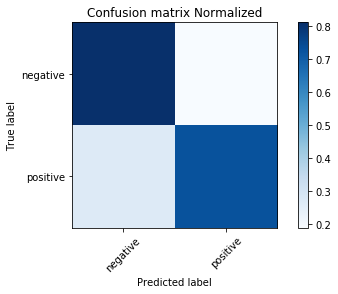

In [23]:
evaluate_prediction(predicted, test_data.sentiment)

In [24]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data['sentiment'])
predicted = logreg.predict(X_test_word_average)



/home/richard/home/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 3.53 s, sys: 215 ms, total: 3.74 s
Wall time: 22.8 s


In [24]:
X_train_word_average

NameError: name 'X_train_word_average' is not defined

accuracy 0.8613
confusion matrix
 [[4322  712]
 [ 675 4291]]
(row=expected, col=predicted)


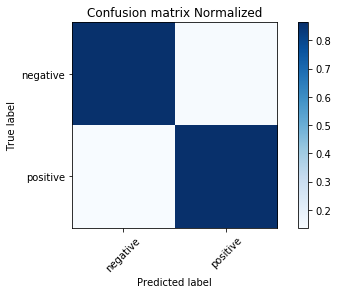

In [25]:
evaluate_prediction(predicted, test_data.sentiment)

In [22]:
df1=train_data[['sentiment']]

In [23]:
X=X_train_word_average
y=df1.values
xPredicted=X_test_word_average
y.shape

NameError: name 'X_train_word_average' is not defined

In [ ]:
class Neural_Network(object):
    def __init__(self):
        #parameters
        self.inputSize = 300
        self.outputSize = 1
        self.hiddenSize = 500
        #weights
        self.W1 = np.random.randn(self.inputSize,self.hiddenSize)  # (3x2) weight matrix from input to hidden layer
        #print("W1",self.W1)

        self.W2 = np.random.randn(self.hiddenSize,self.outputSize)  # (3x1) weight matrix from hidden to output layer
        #print("W2",self.W2)
                
    def forward(self, X):
        #forward propagation through our network
        self.z = np.dot(
            X,
            self.W1)  # dot product of X (input) and first set of 3x2 weights
        self.z2 = self.sigmoid(self.z)  # activation function
        self.z3 = np.dot(
            self.z2, self.W2
        )  # dot product of hidden layer (z2) and second set of 3x1 weights
        o = self.sigmoid(self.z3)  # final activation function

        return o

    def sigmoid(self, s):
        # activation function
        return 1 / (1 + np.exp(-s))

    def sigmoidPrime(self, s):
        #derivative of sigmoid
        return s * (1 - s)

    def backward(self, X, y, o):
        # backward propgate through the networ
        #print("y",y)
        #print("o",o)
        self.o_error = y - o  # error in output
        self.o_delta = self.o_error * self.sigmoidPrime(
            o)  # applying derivative of sigmoid to error

        self.z2_error = self.o_delta.dot(
            self.W2.T
        )  # z2 error: how much our hidden layer weights contributed to output error
        self.z2_delta = self.z2_error * self.sigmoidPrime(
            self.z2)  # applying derivative of sigmoid to z2 error

        self.W1 += X.T.dot(
            self.z2_delta)  # adjusting first set (input --> hidden) weights
        self.W2 += self.z2.T.dot(
            self.o_delta)  # adjusting second set (hidden --> output) weights

    def train(self, X, y):
        o = self.forward(X)
        self.backward(X, y, o)

    def saveWeights(self):
        np.savetxt("w1.txt", self.W1, fmt="%s")
        np.savetxt("w2.txt", self.W2, fmt="%s")

    def predict(self):
        print ("Predicted data based on trained weights: ")
        print ("Input (scaled): \n" + str(xPredicted))
        #print ("Output: \n" + str(self.forward(xPredicted)))
        a=self.forward(xPredicted)
        print("a",a.shape[1])
        for i in range (a.shape[0]):
            if(a[i][0]>.5):
                print("ok",a[i][0])
                a[i][0]=1
                con1=con1+1
            else:
                #print("ok",a[i][0])
                a[i][0]=0
                con0=con0+1
        print("1 ",con1)
        print("0 ",con0)
        return a
  




In [ ]:
NN = Neural_Network()
for i in range(100): # trains the NN 1,000 times
    print (" #" + str(i) + "\n")
    #print ("Input (scaled): \n" + str(X))
    #print ("Actual Output: \n" + str(y))
    print ("Predicted Output: \n" + str(NN.forward(X)))
    print ("error Loss: \n" + str(np.mean(np.square(y - NN.forward(X)))))  # mean sum squared loss
    #print('accuracy %s' % accuracy_score(y, NN.forward(X)))
    print("\n")
    NN.train(X, y)

NN.saveWeights()
a=NN.predict()

W1 [[ 0.44853733  0.00717194 -1.91352848 ... -1.33681132 -0.06554715
  -0.8077594 ]
 [-0.82590394  2.13732229 -0.410852   ... -0.62964535 -0.33473799
  -0.24184457]
 [-0.18664628 -0.06766442  0.67785783 ... -1.515259   -0.7520752
  -0.37168977]
 ...
 [ 1.32377689 -0.98680834  0.21334526 ...  0.39758989 -0.09149863
   0.21402027]
 [-0.19196271  0.39644795  0.79765378 ... -0.9811287  -0.93363851
  -0.26045984]
 [ 0.96601478  0.36939555  2.11363772 ... -0.5785771  -1.6064874
  -1.41679813]]
W2 [[-1.78928024e+00]
 [ 4.36289066e-01]
 [-1.55614588e+00]
 [ 1.62744571e+00]
 [-4.89933611e-01]
 [-4.12605887e-01]
 [ 8.69573982e-02]
 [ 2.23773457e+00]
 [ 8.24155642e-01]
 [-2.48166734e-01]
 [ 7.66916065e-01]
 [ 1.04570961e+00]
 [ 2.11537921e+00]
 [-6.17444365e-01]
 [ 3.68137152e-01]
 [-5.23320772e-01]
 [ 1.22642833e+00]
 [-5.16824225e-01]
 [ 1.26084869e+00]
 [-1.34662731e+00]
 [-6.00459636e-02]
 [ 6.77761462e-01]
 [-1.74501490e-01]
 [ 4.33747376e-01]
 [-4.79661547e-01]
 [ 1.03234763e+00]
 [-1.26988

Predicted Output: 
[[0.98240911]
 [0.59400119]
 [0.20514576]
 ...
 [0.5796612 ]
 [0.3400583 ]
 [0.84345744]]
error Loss: 
0.38859543586832523


